In [1]:
#Import All the Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import tensorflow as tf

path = "C:/Users/parth/Desktop/Git/Projects/DigitRecognizer/Data/"

In [2]:
#Read the Train file
train_df = pd.read_csv(path+'train.csv')
print(train_df.info())

train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first column of the Train Data contains the actual numbers and the rest of the columns contain the pixels of the picture. There are 784 columns of pixels which is the flattened array of the 28x28 image data.

Let's extract the image data and image labels from the Train Data.

In [3]:
train_images = train_df.iloc[:,1:].values
train_images = train_images.astype(np.float)
train_labels = train_df[[0]].values.ravel()

Each row is an image. Let's extract the image of first 8 pictures and plot them.

Labels:  [1, 0, 1, 4, 0, 0, 7, 3]


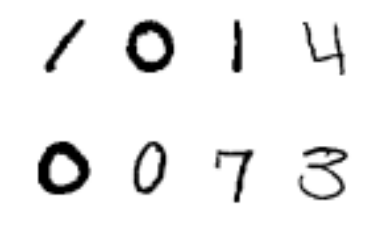

In [4]:
print('Labels: ',[i for i in train_labels[:8]])

for i in range(8):
    image = train_images[i].reshape(28,28)
    #print(image)
    plt.subplot(2,4,i+1)
    plt.axis('off')
    plt.imshow(image,cmap=cm.binary)


Let's bring the image pixel data from range of 0 to 255 -> 0 to 1.

In [5]:
train_images = np.multiply(train_images, 1.0 / 255.0)

Use OneHot Encoder to convert the Labels.

0->[1 0 0 0 0 0 0 0 0 0]

1->[0 1 0 0 0 0 0 0 0 0]

....

9->[0 0 0 0 0 0 0 0 0 1]

In [6]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(train_labels, 10)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(0,labels[0]))

labels(42000,10)
labels[0] => [0 1 0 0 0 0 0 0 0 0]


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_images, labels, test_size=0.2,random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(33600, 784)
(33600, 10)
(8400, 784)
(8400, 10)


# Tensorflow Graph

Define Weights and Biases function

Weight Initialization

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

Define Convolution and Max Pooling function

In [9]:
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

conv2d:
Computes a 2-D convolution given 4-D input and filter tensors.

Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel 
tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:

Flattens the filter to a 2-D matrix with shape [filter_height * filter_width * in_channels, output_channels].
Extracts image patches from the input tensor to form a virtual tensor of 
shape [batch, out_height, out_width, filter_height * filter_width * in_channels].
For each patch, right-multiplies the filter matrix and the image patch vector.

max_pool_2x:
Performs the max pooling on the input.

Args:

value: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor.
strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor.
padding: A string, either 'VALID' or 'SAME'. The padding algorithm. 
data_format: A string. 'NHWC' and 'NCHW' are supported.
name: Optional name for the operation.

In [10]:
# input & output of NN
# images
x = tf.placeholder('float', shape=[None, 784])
# labels
y_ = tf.placeholder('float', shape=[None, 10])

x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation. We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of floating-point numbers, with a shape [None, 784]. (Here None means that a dimension can be of any length.)

y_ is a new placeholder to input the correct answers.

First Convolution Layer

It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [11]:
W_conv1 = weight_variable([5,5,1,32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [12]:
x_image = tf.reshape(x,[-1,28,28,1])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The max_pool_2x2 method will reduce the image size to 14x14.

In [13]:
h_conv1 = tf.nn.relu(conv2d(x_image,W_conv1)+b_conv1)
h_pool = max_pool_2x2(h_conv1)

In [14]:
# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, 28, 28, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, 28*4, 28*8)) 

Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [15]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool,W_conv2)+b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [16]:
W_fc1 = weight_variable([7*7*64,1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2,[-1,7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,W_fc1)+b_fc1)

Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

In [17]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob)

Add SoftMax Regression Layer:

In [18]:
W_fc2= weight_variable([1024,10])
b_fc2 = bias_variable([10])

y = tf.nn.softmax(tf.matmul(h_fc1_drop,W_fc2) + b_fc2)

Loss can be found using Cross Entropy
Optimization will be done using ADAMOptimizer

In [19]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

Prediction

In [20]:
predict = tf.argmax(y,1)

In [21]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [22]:
import math

# A mildly random version....simply pick one of the (consecutive) slices of size "size"
from random import randint

# This is used below, for simplicity and for faster convergence ;)
def random_batch(data,labels,size):
    value = math.floor(len(data) / size)    
    intervall = randint(0,value-1)
    return data[intervall*size:intervall*(size+1)],labels[intervall*size:intervall*(size+1)]

# print(random_batch(trainfv,ohtrainLabelsNdarray,3))

from random import sample

# of course, this could be done in a myriad of (better) ways...
# This "random" picking (not subarray-wise, as above) leads to far slower
# learning - which justifies the assumption that "similar" digits (from
# the same writer perhaps) which we want too learn to differentiate, 
# often are close together in the original data, making it useful to learn
# them together in batches
def really_random_batch(data,labels,size):
    res_data = np.empty((size,784))
    res_label = np.empty((size,10))
    
    l = len(data)
    s = sample(range(l), size)
    
    for i in range(size):
        res_data[i] = data[i]
        res_label[i] = labels[i]
        
    return np.array(res_data),np.array(res_label)

In [23]:
'''
# Training (go higher for better results, e.g. 1500)
for i in range(20000):
    batch_xs, batch_ys = random_batch(X_train,Y_train,50)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if not(i % 50): 
        print(i)

# Test our prediction 
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("\nAccuracy of the current model: ",sess.run(accuracy, feed_dict={x: trainfv[0:10000],
                                   y_: ohtrainLabelsNdarray[0:10000]}))
'''

'\n# Training (go higher for better results, e.g. 1500)\nfor i in range(20000):\n    batch_xs, batch_ys = random_batch(X_train,Y_train,50)\n    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})\n    if not(i % 50): \n        print(i)\n\n# Test our prediction \ncorrect_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))\naccuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))\nprint("\nAccuracy of the current model: ",sess.run(accuracy, feed_dict={x: trainfv[0:10000],\n                                   y_: ohtrainLabelsNdarray[0:10000]}))\n'

In [24]:
for i in range(10000):
    batch_xs, batch_ys = random_batch(train_images,labels,100)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={x: X_val, y_: Y_val, keep_prob: 1.0}))

step 0, training accuracy 0.0608696
step 1000, training accuracy 0.927273
step 2000, training accuracy 0.968254
step 3000, training accuracy 0.994911
step 4000, training accuracy 1
step 5000, training accuracy 0.996743
step 6000, training accuracy 0.990385
step 7000, training accuracy 1
step 8000, training accuracy 1
step 9000, training accuracy 1
test accuracy 0.997619


In [25]:
# read test data from CSV file 
test_images = pd.read_csv(path+'test.csv').values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))

test_images(28000,784)


In [26]:
BATCH_SIZE = 50
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], keep_prob: 1.0})

In [27]:
print('predicted_lables({0})'.format(len(predicted_lables)))

# output test image and prediction
#display(test_images[IMAGE_TO_DISPLAY])
#print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# save results
np.savetxt(path+'submission_softmax2.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

predicted_lables(28000)
